# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 07.10.2023

Мягкий дедлайн: 23:59MSK 20.10.2023

Жесткий дедлайн: 23:59MSK 24.10.2023

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. За каждый день просрочки снимается 1 балл. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Итогова оценка считается как
$$
min(task_1, task_2)*0.6 + max(task_1, task_2)*0.2 + task_4*0.2
$$

где $task_1$, $task_2$ и $task_4$ - оценки за первое и второе заданиее соответсвенно.
Также, за домашнее задание выставляется 0, если не сделано нулевое или третье задание.
### О задании

В этом задании вам предстоит предсказывать год выпуска песни (**задача регрессии**) по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [2]:
DEVICE

device(type='cuda')

In [3]:
import os
if not os.path.exists("data.txt.zip"):
    !wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
    assert os.path.exists("data.txt.zip")

In [4]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


Мы вывели кусок данных, чтобы понять, насколько они пригодны для работы без изменений. Здесь ясно, что сомнительно дальше с такими данными работать, потому что как минимум есть отрицательные значения, которые не отмасштабированы, кроме того еще сразу бросается в глаза совсем разная размерность, где-то видим реально большие числа, а где-то 0.075. Ясно, что будем скейлить.

In [5]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

Для выполнения данного задания (и всех последующих) предобработайте данные.

1. Зафиксируйте random_seed везде где только возможно. Вам предоставлена функция для этого, однако вы можете дополнить ее своими дополнениями
2. Обучите StandertScaler и предобработайте ваши данные. В следующих заданиях можете использовать другой scaler или вообще отказаться от него


In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    # Add smth here if you need...

In [8]:
set_random_seed(42)

In [9]:
from sklearn.linear_model import Ridge
from sklearn.metrics import root_mean_squared_error

model = Ridge().fit(X_train, y_train)
rmse_for_model = root_mean_squared_error(y_test, model.predict(X_test))
rmse_for_model

9.510160818523266

Лучшая константа для RMSE это среднее, посчитаем значение метрики при нем

In [10]:
best_rmse_metric = root_mean_squared_error(y_test, np.full_like(a=y_test, fill_value=np.mean(y_train)))
best_rmse_metric

10.863228020678134

## Задание 1. (максимум 10 баллов)

Закрепите свои знания о том, как pytorch работает с обратным распространением ошибки, проделав следующие шаги:

1. Создайте модель линейной регрессии, которая будет состоять только из одного Linear слоя.
2. Напишите цикл обучения вашей линейной регрессии. В нем реализуйте подсчет функции потерь, сделайте шаг градиентного спуска. Запрещено использовать готовые оптимизаторы и loss-функции из библиотеки pytorch. Для подсчета градиента воспользуйтесь методом backward.
3. Запустите обучение на 10 эпохах, после каждой проверяйте значение целевой метрики на тестовой выборке.
4. Выведите на экран графики метрики и значения функции потерь на тестовой и обучающей выборке.

В данном задании нет цели побить какой-то порог по метрике. Ваша задача - убедиться в том, что ваш рукописный цикл обучения работает. Для ускорения вычислений и обучения модели можете брать только срез данных, а не весь датасет.

In [11]:
import torch.nn as nn
from IPython.display import clear_output

def plot_train_and_test_loss(train_loss: list, test_loss: list):
    n = len(train_loss)
    assert len(test_loss) == n
    epochs = np.arange(1, n + 1, dtype=np.uint32)

    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
    fig.suptitle("Train and test loss values")

    ax1.set_xlabel("$epoch$")
    ax1.set_ylabel("$loss$")
    ax1.plot(epochs, train_loss, color="r", label="train loss")
    ax1.legend(loc="upper right")
    ax1.grid()
    ax1.ticklabel_format(axis="both", style="plain", useOffset=False)

    ax2.set_xlabel("$epoch$")
    ax2.set_ylabel("$loss$")
    ax2.plot(epochs, test_loss, color="g", label="test loss")
    ax2.legend(loc="upper right")
    ax2.grid()
    ax2.ticklabel_format(axis="both", style="plain", useOffset=False)

    plt.show()

def train_epoch(simple_model: nn.Linear, X_train, y_train, lr=0.005):
    simple_model.train()

    simple_model.weight.grad = None
    simple_model.bias.grad = None

    model_out = simple_model(X_train)
    assert isinstance(model_out, torch.Tensor) and len(model_out) == len(y_train)

    train_loss = torch.sqrt(torch.mean((model_out - y_train)**2))
    train_loss.backward()
    train_loss_numpy = train_loss.detach().cpu().numpy()

    simple_model.weight.data.sub_(simple_model.weight.grad.data, alpha=lr)
    simple_model.bias.data.sub_(simple_model.bias.grad.data, alpha=lr)

    return train_loss_numpy

def test_epoch(simple_model: nn.Linear, X_test, y_test):
    simple_model.eval()
    with torch.no_grad():
        model_out = simple_model(X_test)
        test_loss = torch.sqrt(torch.mean((model_out - y_test)**2))
        return test_loss.detach().cpu().numpy()

def train_and_test_with_plot(simple_model: nn.Linear, lr=0.005, n_epoch=10):
    N = 12000
    X_train_torch = torch.from_numpy(X_train[:N].astype(np.float32)).to(device=DEVICE)
    y_train_torch = torch.from_numpy(y_train[:N].astype(np.float32)).to(device=DEVICE)
    X_test_torch = torch.from_numpy(X_test[:N].astype(np.float32)).to(device=DEVICE)
    y_test_torch = torch.from_numpy(y_test[:N].astype(np.float32)).to(device=DEVICE)

    train_loss_history = []
    test_loss_history = []

    for _ in range(n_epoch):
        train_loss_history.append(train_epoch(simple_model, X_train=X_train_torch, y_train=y_train_torch, lr=lr))
        test_loss_history.append(test_epoch(simple_model, X_test=X_test_torch, y_test=y_test_torch))
        plot_train_and_test_loss(train_loss_history, test_loss_history)


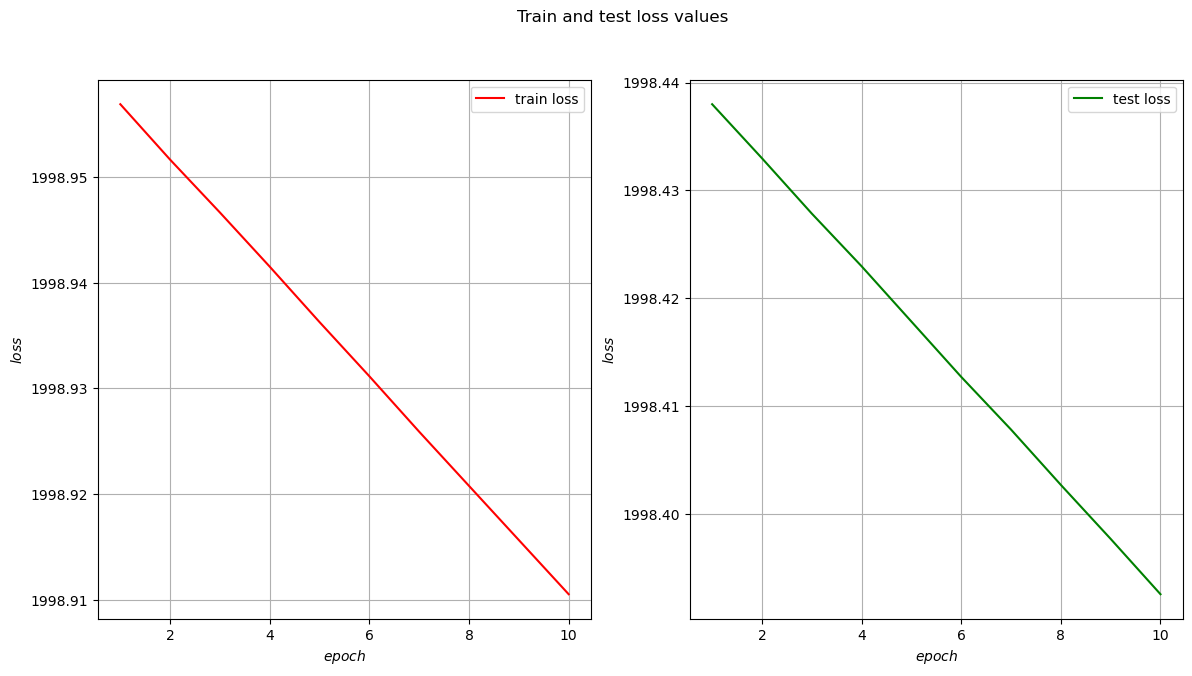

In [12]:
set_random_seed(0xdeadbeef)

model = nn.Linear(in_features=X.shape[1], out_features=1, bias=True, device=DEVICE)
train_and_test_with_plot(model)

## Задание 2. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Не забудьте, что для улучшения качества модели вам поможет **нормировка таргета**.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из предыдущего задания.



Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться сигнатурами функций, которые приведены ниже. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

In [36]:
from torch.utils.data import Dataset, DataLoader

class ArraysDataset(Dataset):
    def __init__(self, X, y):
        assert len(X) == len(y)
        self.__X = X
        self.__y = y
        self.__X_getter = ArraysDataset.__select_getter(self.__X)
        self.__y_getter = ArraysDataset.__select_getter(self.__y)

    def __len__(self):
        return len(self.__X)

    def __getitem__(self, idx):
        return self.__X_getter(self.__X, idx), self.__y_getter(self.__y, idx)

    @staticmethod
    def __select_getter(x):
        match x:
            case pd.DataFrame() | pd.Series():
                return ArraysDataset.__pandas_getter
            case np.ndarray():
                return ArraysDataset.__numpy_getter
            case torch.Tensor():
                return ArraysDataset.__torch_getter
            case _:
                raise ValueError(f"Could not deduce how to address input dataset {X:!r}")

    @staticmethod
    def __pandas_getter(x: pd.DataFrame | pd.Series, idx):
        return x.iloc[idx].to_numpy(dtype=np.float32)

    @staticmethod
    def __numpy_getter(x: np.ndarray, idx):
        return x[idx].astype(dtype=np.float32)

    @staticmethod
    def __torch_getter(x: torch.Tensor, idx):
        return x[idx].to(dtype=torch.float32)

class SimpleModel(nn.Module):
    class SkipConnection(nn.Module):
        def __init__(self, *args: nn.Module):
            super().__init__()
            self.__model = nn.Sequential(*args)

        def train(self, mode: bool = True):
            self.__model.train(mode)

        def eval(self):
            self.__model.eval()

        def forward(self, x):
            return self.__model(x) + x

    def __init__(self, input_size: int, device: torch.device = DEVICE):
        super().__init__()
        hidden_size = input_size << 1
        a = 0.02

        fc1 = nn.Linear(in_features=input_size, out_features=hidden_size, bias=True, device=device)
        act1 = nn.LeakyReLU(negative_slope=a)
        torch.nn.init.kaiming_normal_(fc1.weight, a=a, nonlinearity='leaky_relu')

        fc2 = nn.Linear(in_features=fc1.out_features, out_features=hidden_size, bias=True, device=device)
        act2 = nn.LeakyReLU(negative_slope=a)
        torch.nn.init.kaiming_normal_(fc2.weight, a=a, nonlinearity='leaky_relu')

        fc3 = nn.Linear(in_features=fc2.out_features, out_features=1, bias=True, device=device)

        self.__model = nn.Sequential(
            fc1,
            nn.BatchNorm1d(num_features=fc1.out_features, device=device),
            act1,
            SimpleModel.SkipConnection(
                fc2,
                nn.BatchNorm1d(num_features=fc2.out_features, device=device),
                act2,
            ),
            fc3,
        )
        self.__device = device

    def forward(self, x):
        return self.__model(x).reshape(-1)

    def train(self, mode: bool = True):
        self.__model.train(mode)

    def eval(self):
        self.__model.eval()

    def mutable_parameters(self):
        return self.parameters()

    def device(self):
        return self.__device

    @staticmethod
    def from_x_train(X, device: torch.device = DEVICE) -> "SimpleModel":
        match (X.shape if hasattr(X, "shape") else len(X)):
            case (x_train_samples_count, input_size):
                input_size = int(input_size)
            case x_train_samples_count if isinstance(x_train_samples_count, int):
                input_size = 1
            case _:
                raise ValueError(f"Could not deduce size of the samples in the train dataset {X}")

        return SimpleModel(input_size=input_size, device=device)


In [37]:
from torch.optim import SGD, AdamW
from torch.nn.functional import mse_loss as mse

set_random_seed(0xdeadbeef)

y_mean = torch.tensor(data=y.mean(), dtype=torch.float32, device=DEVICE, requires_grad=False)
y_std = torch.tensor(data=y.std(), dtype=torch.float32, device=DEVICE, requires_grad=False)

def transform(y):
    return (y - y_mean.cpu().numpy()) / y_std.cpu().numpy()

def inverse_transform(y):
    return y * y_std + y_mean

def rmse(y_gt, y_pred):
    # return torch.sqrt(mse(y_gt, y_pred))
    return torch.sqrt(torch.mean(torch.square(y_gt - y_pred)))

train_batchsize = 89
train_set = ArraysDataset(X_train, transform(y_train))
train_loader = DataLoader(dataset=train_set, batch_size=train_batchsize, shuffle=True)

test_batchsize = 512
test_set = ArraysDataset(X_test, y_test)
test_loader = DataLoader(dataset=test_set, batch_size=test_batchsize, shuffle=False)

model = SimpleModel.from_x_train(X_train)
optimizer = SGD(params=model.mutable_parameters(), lr=0.001, momentum=0.01, weight_decay=0.01)
criterion = rmse

In [315]:
def plot_history_on_axes(loss_history, ax, stage: str):
    epochs = np.arange(1, len(loss_history) + 1, dtype=np.int32)
    ax.set_xlabel("$epoch$")
    ax.set_ylabel("$loss$")
    ax.plot(epochs, loss_history, color="g", label=f"{stage} loss")
    ax.legend(loc="upper right")
    ax.grid()
    ax.ticklabel_format(axis="both", style="plain", useOffset=False)

def plot_train_epochs(train_loss_history, val_loss_history, normalized_target=False):
    clear_output(wait=True)
    train_label = "train (with normalized target)" if normalized_target else "train"
    if val_loss_history:
        _fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
        plot_history_on_axes(train_loss_history, ax1, train_label)
        plot_history_on_axes(val_loss_history, ax2, "validation")
    else:
        _fig, ax = plt.subplots(figsize=(16, 6))
        plot_history_on_axes(train_loss_history, ax, train_label)
    plt.show()

def train(model: nn.Module, optimizer: torch.optim.Optimizer, criterion, train_loader: DataLoader, test_loader, epochs_count: int = 50):
    """
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
        test_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
        epochs_count - number of the train epochs
    """

    train_loss_history = []
    should_validate = test_loader is not None
    val_loss_history = []
    for _ in range(epochs_count):
        model.train()
        loss_over_batches = []
        for x_train_batch, y_train_batch in tqdm(train_loader, "Iterating over train dataset batches"):
            optimizer.zero_grad()
            model_pred = model(x_train_batch.to(device=DEVICE))
            loss = criterion(y_train_batch.to(device=DEVICE), model_pred)

            loss.backward()
            optimizer.step()

            loss_over_batches.append(loss.detach().cpu().numpy())

        train_loss_history.append(np.mean(loss_over_batches))

        if should_validate:
            model.eval()
            loss_over_batches = []
            with torch.no_grad():
                for x_test_batch, y_test_batch in tqdm(test_loader, "Iterating over validation dataset batches"):
                    model_pred = inverse_transform(model(x_test_batch.to(device=DEVICE)).detach())
                    loss = criterion(y_test_batch.to(device=DEVICE), model_pred)
                    loss_over_batches.append(loss.cpu().numpy())

            val_loss_history.append(np.mean(loss_over_batches))

        plot_train_epochs(train_loss_history, val_loss_history, normalized_target=True)
        print(f"Current mean train loss: {train_loss_history[-1]}\nmin seen train loss: {np.min(train_loss_history)}")
        if should_validate:
            print(f"Current validation loss: {val_loss_history[-1]}\nmin seen validation loss: {np.min(val_loss_history)}")

def test(model: nn.Module, criterion, test_loader: DataLoader):
    """
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn
        test_loader - torch.utils.data.Dataloader with test set
    ----------
    returns:
        predicts - torch.tensor with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
    """
    model.eval()
    predicts = []
    loss_over_batches = []
    with torch.no_grad():
        for x_test_batch, y_test_batch in tqdm(test_loader, "Iterating over test dataset batches"):
            model_pred = inverse_transform(model(x_test_batch.to(device=DEVICE)).detach())
            loss = criterion(y_test_batch.to(device=DEVICE), model_pred)
            loss_over_batches.append(loss.cpu().numpy())
            predicts.extend(model_pred.cpu().tolist())

    print(f"Mean loss over batches on the test dataset: {np.mean(loss_over_batches)}")

    return torch.FloatTensor(predicts)


In [39]:
assert test(model, criterion, test_loader).shape[0] == y_test.shape[0]

Iterating over test dataset batches:   0%|          | 0/101 [00:00<?, ?it/s]

Mean loss over batches on the test dataset: 19.059877395629883


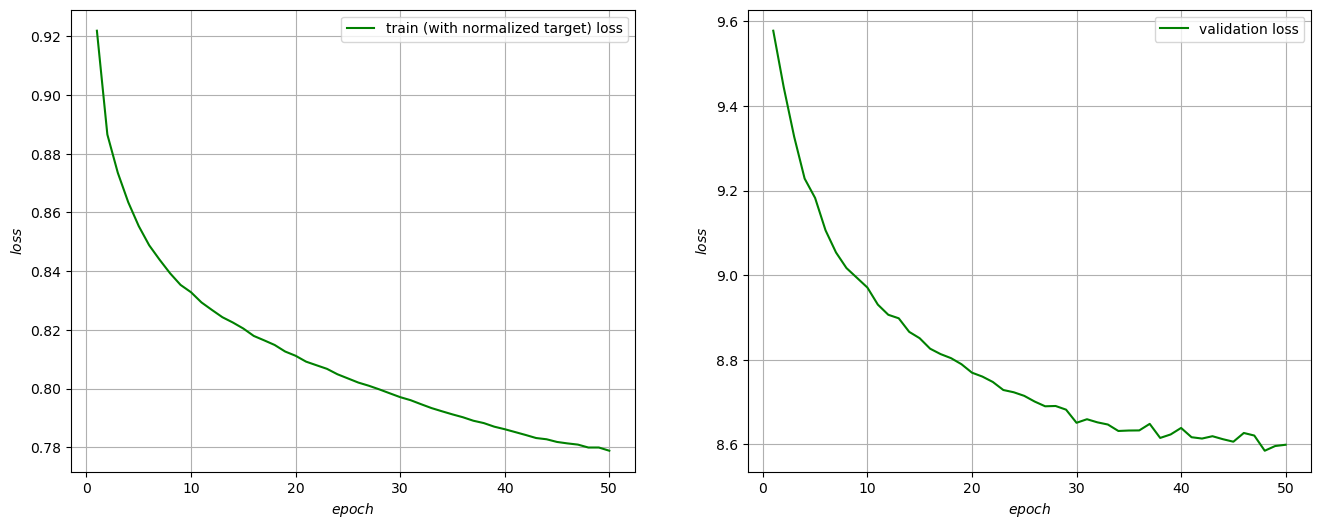

Current mean train loss: 0.7788417339324951
min seen train loss: 0.7788417339324951
Current validation loss: 8.599315643310547
min seen validation loss: 8.585216522216797


In [40]:
assert test(model, criterion, test_loader).shape[0] == y_test.shape[0]

set_random_seed(0xdead & 0xbad)

train(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    train_loader=train_loader,
    test_loader=test_loader,
)

In [41]:
test(model, criterion, test_loader)

Iterating over test dataset batches:   0%|          | 0/101 [00:00<?, ?it/s]

Mean loss over batches on the test dataset: 8.599315643310547


tensor([1997.0366, 2003.5310, 2000.0084,  ..., 2000.3591, 1998.4338,
        2000.9641])

## Задание 3. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

- При решении были применены функция активации leaky relu, методы для снижения переобучения - drop out и batch norm, метод для борьбы с затуханием градиента - skip connections
- Были опробованы 2 оптимизатора: SGD и AdamW с различными гиперпараметрами
- Для трейна был нормализован таргет (при вычислении rmse на тесте предикт модели денормализуется по формуле $\hat{y}_{pred} \cdot \sigma_y + \bar{y}$, где $\sigma_y$ - среднеквадратичное отклонение, посчитанное по $y$ и $\bar{y}$ - среднее значение, посчитанное по $y$)

1. Без нормализации таргета для трейна, при использовании 4 полносвязных слоёв:

    `Linear(16380 params) -> BatchNorm(360 params) -> LeakyReLU -> Linear(32580 params) -> LeakyReLU -> Linear(32580 params) -> BatchNorm(360 params) -> LeakyReLU -> Linear(181 params)`

    с общим числом параметров 82441 и оптимизатором `AdamW(lr=0.005, weight_decay=0.07)` минимальное (среди всех эпох) среднее (по батчам) значение лосса на валидации: 10.540343284606932

2. Без нормализации таргета для трейна, при использовании 4 полносвязных слоёв:

    `Linear(16380 params) -> BatchNorm(360 params) -> LeakyReLU -> Linear(32580 params) -> BatchNorm(360 params) -> LeakyReLU -> BeginSkipConnection1 -> Linear(32580 params) -> BatchNorm(360 params) -> LeakyReLU -> EndSkipConnection1 -> Linear(181 params)`

    с общим числом параметров 82801 и оптимизатором `SGD(lr=0.005, momentum=0.005, weight_decay=0.01)` минимальное (среди всех эпох) среднее (по батчам) значение лосса на валидации: 10.539478302001953

3. Без нормализации таргета для трейна, при использовании 3 полносвязных слоёв:

    `Linear(16380 params) -> BatchNorm(360 params) -> LeakyReLU -> BeginSkipConnection1 -> Linear(32580 params) -> BatchNorm(360 params) -> LeakyReLU -> EndSkipConnection1 -> Linear(181 params)`

    с общим числом параметров 49861 и оптимизатором `SGD(lr=0.001, weight_decay=0.01)` минимальное (среди всех эпох) среднее (по батчам) значение лосса на валидации: 8.837464332580566

4. При нормализации таргета для трейна, использовании 3 полносвязных слоёв:

    `Linear(16380 params) -> BatchNorm(360 params) -> LeakyReLU -> BeginSkipConnection1 -> Linear(32580 params) -> BatchNorm(360 params) -> LeakyReLU -> EndSkipConnection1 -> Linear(181 params)`

    с общим числом параметров 49861 и оптимизатором `SGD(lr=0.001, momentum=0.01, weight_decay=0.01)` минимальное (среди всех эпох) среднее (по батчам) значение лосса на валидации: 8.585216522216797


## Задание 4. (10 баллов)

А теперь давайте попробуем решить задачу классификации на тех же данных!

Протестируйте два варианта:

1. Cчитайте каждый год, представленный в таблице, за отдельный класс

2. Разбейте года на 10 бинов и решайте задачу классификации для 10 классов

Добавьте в test подсчет метрик: accuracy, precision, recall (можете выбрать micro или macro усреднение, как посчитаете нужным).

Что можно сказать о полученных моделях? Почему результаты вышли такими? Напишите небольшой анализ того, что было проделано, чем модели классификации отличаются от задачи регрессии и друг друга?

Распределение годов в датасете:

<Axes: >

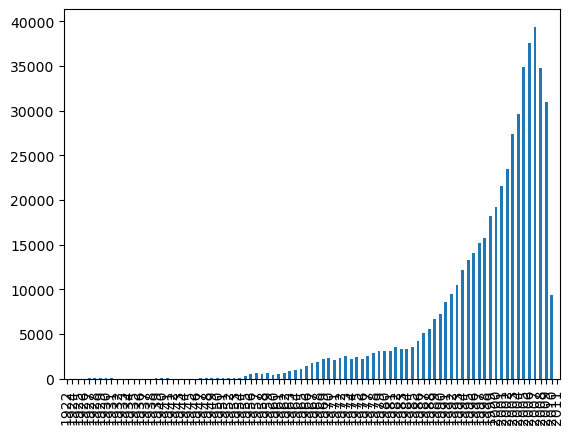

In [316]:
pd.Series(y).value_counts().sort_index().plot(kind="bar")

Для разбиения классов на 10 бинов так, чтобы попытаться соблюсти баланс классов, воспользуемя жадным алгоритмом (даёт неплохую аппроксимацию)

Т.к. в условии не описано, как нужно выбрать, какие года в какие бины помещать, было решено написать жадник, который поддерживает хипу (структура данных heap) с размером класса + индекс класса и проходится по всем парам {год, количество наблюдений с данным годом}, добавляя очередное количество к наименьшему классу (`heapq.heappush(q, (min_count + count, index_of_class_with_min_count))`) и для каждого года запоминая, к какому классу было добавлено количество наблюдений этого года (`class_to_year[index_of_class_with_min_count].append(year)`)

In [317]:
import heapq

year_to_count = pd.Series(y).value_counts().to_dict()
NUMBER_OF_CLASSES = 10
class_to_year = [list() for _ in range(NUMBER_OF_CLASSES)]
q = [(0, i) for i in range(len(class_to_year))]
heapq.heapify(q)
for year, count in year_to_count.items():
    min_count, index_of_class_with_min_count = heapq.heappop(q)
    class_to_year[index_of_class_with_min_count].append(year)
    heapq.heappush(q, (min_count + count, index_of_class_with_min_count))

year_to_class_index = {}
for class_index, years_per_class in enumerate(class_to_year):
    class_size = sum(year_to_count[year] for year in years_per_class)
    print(f"Years for the class {class_index} (with size {class_size}): {years_per_class}")
    for year in years_per_class:
        assert year not in year_to_class_index
        year_to_class_index[year] = class_index

Years for the class 0 (with size 51514): [2007, 1988, 1984, 1969, 1962, 1953, 1950, 1928, 1945, 1932, 1925]
Years for the class 1 (with size 51514): [2006, 1990, 1983, 1972, 1963, 1949, 1930, 1946, 1938]
Years for the class 2 (with size 51514): [2005, 1992, 1985, 1970, 1964, 1947, 1927, 1934, 1926]
Years for the class 3 (with size 51517): [2008, 1993, 1981, 1976, 1959, 1954, 1952, 1948, 1941, 1935]
Years for the class 4 (with size 51635): [2009, 1994, 1982, 1973, 1967, 1956]
Years for the class 5 (with size 51515): [2004, 1995, 1986, 1975, 1965, 1958, 1929, 1951, 1939, 1936, 1944, 1924]
Years for the class 6 (with size 51514): [2003, 1996, 1987, 1978, 1966, 1961, 1922]
Years for the class 7 (with size 51515): [2002, 1997, 1989, 1979, 1974, 1957, 1955, 1937, 1943, 1933]
Years for the class 8 (with size 51593): [2001, 1998, 2010, 1977, 1968, 1960]
Years for the class 9 (with size 51514): [2000, 1999, 1991, 1980, 1971, 1940, 1931, 1942, 2011]


In [318]:
from sklearn.preprocessing import LabelEncoder

def class_selector_for_years(y: np.ndarray) -> torch.Tensor:
    years_class = torch.tensor(y, requires_grad=False)
    years_class.apply_(year_to_class_index.get)
    return years_class


all_years_encoder = LabelEncoder().fit(y)
y_years_classes_train = all_years_encoder.transform(y_train)
y_years_classes_test = all_years_encoder.transform(y_test)
y_ten_classes_train = class_selector_for_years(y_train)
y_ten_classes_test = class_selector_for_years(y_test)

Распределение получившихся 10 классов на трейне:

<Axes: >

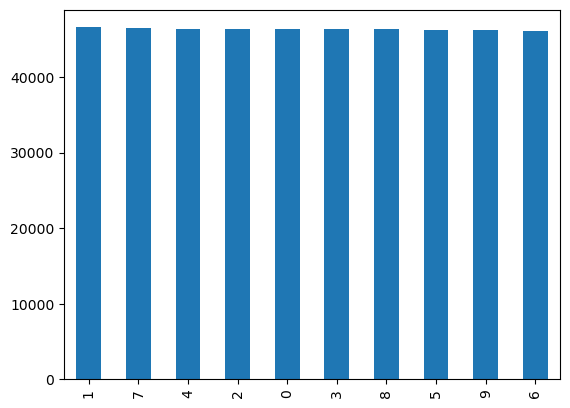

In [319]:
pd.Series(y_ten_classes_train.numpy()).value_counts().plot(kind="bar")

Распределение получившихся 10 классов на тесте:

<Axes: >

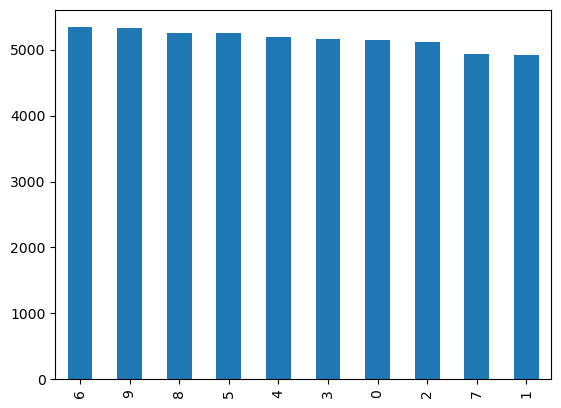

In [320]:
pd.Series(y_ten_classes_test.numpy()).value_counts().plot(kind="bar")

In [321]:
class ClassificationDataset(Dataset):
    def __init__(self, X, y):
        assert len(X) == len(y)
        self.__X = X
        self.__y = y
        self.__X_getter = ClassificationDataset.__select_X_getter(self.__X)
        self.__y_getter = ClassificationDataset.__select_y_getter(self.__y)

    def __len__(self):
        return len(self.__X)

    def __getitem__(self, idx):
        return self.__X_getter(self.__X, idx), self.__y_getter(self.__y, idx)

    @staticmethod
    def __select_X_getter(x):
        match x:
            case pd.DataFrame() | pd.Series():
                return ClassificationDataset.__pandas_X_getter
            case np.ndarray():
                return ClassificationDataset.__numpy_X_getter
            case torch.Tensor():
                return ClassificationDataset.__torch_X_getter
            case _:
                raise ValueError(f"Could not deduce how to address input dataset {x:!r}")

    @staticmethod
    def __select_y_getter(y):
        match y:
            case pd.DataFrame() | pd.Series():
                return ClassificationDataset.__pandas_y_getter
            case np.ndarray():
                return ClassificationDataset.__numpy_y_getter
            case torch.Tensor():
                return ClassificationDataset.__torch_y_getter
            case _:
                raise ValueError(f"Could not deduce how to address input dataset {y:!r}")


    @staticmethod
    def __pandas_X_getter(x: pd.DataFrame | pd.Series, idx):
        return x.iloc[idx].to_numpy(dtype=np.float32)

    @staticmethod
    def __numpy_X_getter(x: np.ndarray, idx):
        return x[idx].astype(dtype=np.float32)

    @staticmethod
    def __torch_X_getter(x: torch.Tensor, idx):
        return x[idx].to(dtype=torch.float32)

    @staticmethod
    def __pandas_y_getter(x: pd.DataFrame | pd.Series, idx):
        return x.iloc[idx].to_numpy()

    @staticmethod
    def __numpy_y_getter(x: np.ndarray, idx):
        return x[idx]

    @staticmethod
    def __torch_y_getter(x: torch.Tensor, idx):
        return x[idx]

class SimpleClassificationModel(nn.Module):
    def __init__(self, input_size: int, n_classes: int, device: torch.device = DEVICE):
        super().__init__()
        hidden_size = input_size << 1
        a = 0.02

        fc1 = nn.Linear(in_features=input_size, out_features=hidden_size, bias=True, device=device)
        act1 = nn.LeakyReLU(negative_slope=a)
        torch.nn.init.kaiming_normal_(fc1.weight, a=a, nonlinearity='leaky_relu')

        fc2 = nn.Linear(in_features=fc1.out_features, out_features=hidden_size, bias=True, device=device)
        act2 = nn.LeakyReLU(negative_slope=a)
        torch.nn.init.kaiming_normal_(fc2.weight, a=a, nonlinearity='leaky_relu')

        fc3 = nn.Linear(in_features=fc2.out_features, out_features=hidden_size >> 2, bias=True, device=device)
        act3 = nn.LeakyReLU(negative_slope=a)
        torch.nn.init.kaiming_normal_(fc3.weight, a=a, nonlinearity='leaky_relu')

        fc4 = nn.Linear(in_features=fc3.out_features, out_features=n_classes, bias=True, device=device)

        self.__model = nn.Sequential(
            fc1,
            nn.BatchNorm1d(num_features=fc1.out_features, device=device),
            act1,
            SimpleModel.SkipConnection(
                fc2,
                nn.BatchNorm1d(num_features=fc2.out_features, device=device),
                act2,
            ),
            fc3,
            nn.BatchNorm1d(num_features=fc3.out_features, device=device),
            act3,
            fc4,
            # nn.Softmax(),
        )
        self.__device = device
        self.__n_classes = n_classes

    def forward(self, x):
        return self.__model(x)

    def train(self, mode: bool = True):
        self.__model.train(mode)

    def eval(self):
        self.__model.eval()

    def mutable_parameters(self):
        return self.parameters()

    def n_classes(self) -> int:
        return self.__n_classes

    def device(self):
        return self.__device

    @staticmethod
    def from_x_y(X, y, device: torch.device = DEVICE) -> "SimpleClassificationModel":
        match (X.shape if hasattr(X, "shape") else len(X)):
            case (x_train_samples_count, input_size):
                input_size = int(input_size)
            case x_train_samples_count if isinstance(x_train_samples_count, int):
                input_size = 1
            case _:
                raise ValueError(f"Could not deduce size of the samples in the train dataset {X}")

        return SimpleClassificationModel(input_size=input_size, n_classes=len(np.unique(y)), device=device)


In [322]:
from enum import IntEnum
from sklearn.metrics import confusion_matrix


class AveragingMode(IntEnum):
    Micro = 0
    Macro = 1


class MetricsMonitor:
    def __init__(self, n_classes: int):
        assert n_classes > 0
        self.__n_classes = n_classes
        self.clear()

    def clear(self):
        n_classes = self.__n_classes
        self.__confusion_matrix = np.zeros(shape=(n_classes, n_classes), dtype=np.int64)

    def update(self, y_ground_truth: torch.Tensor, y_pred: torch.Tensor):
        assert len(y_ground_truth) == len(y_pred)
        C = self.__confusion_matrix
        cm = confusion_matrix(y_true=y_ground_truth.cpu(), y_pred=y_pred.cpu())
        cm = np.pad(cm, ((0, C.shape[0] - cm.shape[0]), (0, C.shape[1] - cm.shape[1])), constant_values=0)
        C += cm

    def TP_of_class(self, class_index: int):
        assert class_index < self.__n_classes
        C = self.__confusion_matrix
        return C[class_index][class_index]

    def TN_of_class(self, class_index: int):
        assert class_index < self.__n_classes
        C = self.__confusion_matrix
        return C.sum() - C[class_index,:].sum() - C[:,class_index].sum() + C[class_index, class_index]

    def FP_of_class(self, class_index: int):
        assert class_index < self.__n_classes
        C = self.__confusion_matrix
        return C.sum() - C[class_index,:].sum()

    def FN_of_class(self, class_index: int):
        assert class_index < self.__n_classes
        C = self.__confusion_matrix
        return C.sum() - C[:,class_index].sum()

    def confusion_matrix(self):
        return self.__confusion_matrix

    def accuracy(self):
        C = self.__confusion_matrix
        val = np.trace(C) / C.sum()
        return val

    def precision(self, metrics_averaging_mode: AveragingMode):
        match metrics_averaging_mode:
            case AveragingMode.Micro:
                return self.__precision_micro()
            case AveragingMode.Macro:
                return self.__precision_macro()
            case _:
                raise ValueError(metrics_averaging_mode)

    def recall(self, metrics_averaging_mode: AveragingMode):
        match metrics_averaging_mode:
            case AveragingMode.Micro:
                return self.__recall_micro()
            case AveragingMode.Macro:
                return self.__recall_macro()
            case _:
                raise ValueError(metrics_averaging_mode)

    def __precision_micro(self):
        tp_sum = 0
        fp_sum = 0
        # TODO: optimize without cycle
        for k in range(self.__n_classes):
            tp_sum += self.TP_of_class(k)
            fp_sum += self.FP_of_class(k)

        denom = tp_sum + fp_sum
        return tp_sum / denom if denom else 0

    def __precision_macro(self):
        sum = 0
        for k in range(self.__n_classes):
            tp_k = self.TP_of_class(k)
            fp_k = self.FP_of_class(k)
            sum += tp_k / (tp_k + fp_k)

        return sum / self.__n_classes

    def __recall_micro(self):
        tp_sum = 0
        fn_sum = 0
        # TODO: optimize without cycle
        for k in range(self.__n_classes):
            tp_sum += self.TP_of_class(k)
            fn_sum += self.FN_of_class(k)

        denom = tp_sum + fn_sum
        return tp_sum / denom if denom else 0

    def __recall_macro(self):
        sum = 0
        for k in range(self.__n_classes):
            tp_k = self.TP_of_class(k)
            fn_k = self.FN_of_class(k)
            sum += tp_k / (tp_k + fn_k)

        return sum / self.__n_classes


def train_classification(model: SimpleClassificationModel,
                         optimizer: torch.optim.Optimizer,
                         criterion,
                         train_loader: DataLoader,
                         test_loader: DataLoader,
                         metrics_averaging_mode: AveragingMode,
                         epochs_count: int = 50):
    train_loss_history = []
    should_validate = test_loader is not None
    val_loss_history = []
    for _ in range(epochs_count):
        train_metrics_monitor = MetricsMonitor(n_classes=model.n_classes())
        val_metrics_monitor = MetricsMonitor(n_classes=model.n_classes())

        model.train()
        loss_over_batches = []
        for x_train_batch, y_train_batch in tqdm(train_loader, "Iterating over train dataset batches"):
            optimizer.zero_grad()
            model_pred = model(x_train_batch.to(device=DEVICE))
            y_train_batch = y_train_batch.to(device=DEVICE)
            loss = criterion(model_pred, y_train_batch)

            loss.backward()
            optimizer.step()

            model_pred_classes = model_pred.argmax(axis=1)
            loss_over_batches.append(loss.detach().cpu().numpy())
            train_metrics_monitor.update(y_ground_truth=y_train_batch, y_pred=model_pred_classes)

        train_loss_history.append(np.mean(loss_over_batches))

        if should_validate:
            model.eval()
            loss_over_batches = []
            with torch.no_grad():
                for x_test_batch, y_test_batch in tqdm(test_loader, "Iterating over validation dataset batches"):
                    model_pred = model(x_test_batch.to(device=DEVICE)).detach()
                    y_test_batch = y_test_batch.to(device=DEVICE)
                    loss = criterion(model_pred, y_test_batch)

                    model_pred_classes = model_pred.argmax(axis=1)
                    loss_over_batches.append(loss.cpu().numpy())
                    val_metrics_monitor.update(y_ground_truth=y_test_batch, y_pred=model_pred_classes)

            val_loss_history.append(np.mean(loss_over_batches))

        plot_train_epochs(train_loss_history, val_loss_history)
        print(f"Current mean train loss: {train_loss_history[-1]}\nmin seen train loss: {np.min(train_loss_history)}")
        print(f"Current train accuracy: {train_metrics_monitor.accuracy()}")
        print(f"Current train precision: {train_metrics_monitor.precision(metrics_averaging_mode)}")
        print(f"Current train recall: {train_metrics_monitor.recall(metrics_averaging_mode)}")
        if should_validate:
            print(f"Current validation loss: {val_loss_history[-1]}\nmin seen validation loss: {np.min(val_loss_history)}")
            print(f"Current validation accuracy: {val_metrics_monitor.accuracy()}")
            print(f"Current validation precision: {val_metrics_monitor.precision(metrics_averaging_mode)}")
            print(f"Current validation recall: {val_metrics_monitor.recall(metrics_averaging_mode)}")


def test_classification(model: SimpleClassificationModel,
                        criterion,
                        test_loader: DataLoader,
                        metrics_averaging_mode: AveragingMode):
    """
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn
        test_loader - torch.utils.data.Dataloader with test set
    ----------
    returns:
        predicts - torch.tensor with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
    """
    model.eval()
    predicts = []
    loss_over_batches = []
    metrics_monitor = MetricsMonitor(n_classes=model.n_classes())
    with torch.no_grad():
        for x_test_batch, y_test_batch in tqdm(test_loader, "Iterating over test dataset batches"):
            model_pred = model(x_test_batch.to(device=DEVICE)).detach()
            y_test_batch = y_test_batch.to(device=DEVICE)
            loss = criterion(model_pred, y_test_batch)

            model_pred_classes = model_pred.argmax(axis=1)
            loss_over_batches.append(loss.cpu().numpy())
            predicts.extend(model_pred_classes.cpu().tolist())
            metrics_monitor.update(y_ground_truth=y_test_batch, y_pred=model_pred_classes)

    print(f"Mean loss over batches on the test dataset: {np.mean(loss_over_batches)}")
    print(f"Accuracy: {metrics_monitor.accuracy()}")
    print(f"Precision: {metrics_monitor.precision(metrics_averaging_mode)}")
    print(f"Recall: {metrics_monitor.recall(metrics_averaging_mode)}")

    return torch.FloatTensor(predicts)

In [323]:
if "model" in locals():
    del model
if "optimizer" in locals():
    del optimizer
if "criterion" in locals():
    del criterion

In [324]:
set_random_seed(0xdeadbeef)

train_batchsize = 120
test_batchsize = 512

years_classes_train_set = ClassificationDataset(X_train, y_years_classes_train)
years_classes_train_loader = DataLoader(dataset=years_classes_train_set, batch_size=train_batchsize, shuffle=True)
years_classes_test_set = ClassificationDataset(X_test, y_years_classes_test)
years_classes_test_loader = DataLoader(dataset=years_classes_test_set, batch_size=test_batchsize, shuffle=False)

ten_classes_train_set = ClassificationDataset(X_train, y_ten_classes_train)
ten_classes_train_loader = DataLoader(dataset=ten_classes_train_set, batch_size=train_batchsize, shuffle=True)
ten_classes_test_set = ClassificationDataset(X_test, y_ten_classes_test)
ten_classes_test_loader = DataLoader(dataset=ten_classes_test_set, batch_size=test_batchsize, shuffle=False)

In [325]:
set_random_seed(0xdeadbeef)

years_classes_model = SimpleClassificationModel.from_x_y(X_train, y_years_classes_train)
years_classes_model_optimizer = SGD(years_classes_model.mutable_parameters(), lr=0.002, weight_decay=0.01)
years_classes_model_criterion = nn.CrossEntropyLoss()

In [326]:
assert test_classification(years_classes_model,
                           years_classes_model_criterion,
                           years_classes_test_loader,
                           AveragingMode.Macro).shape[0] == y_years_classes_test.shape[0]

Iterating over test dataset batches:   0%|          | 0/101 [00:00<?, ?it/s]

Mean loss over batches on the test dataset: 4.775782108306885
Accuracy: 0.010052295177222545
Precision: 0.00011701920940333191
Recall: 0.00011482765894571984


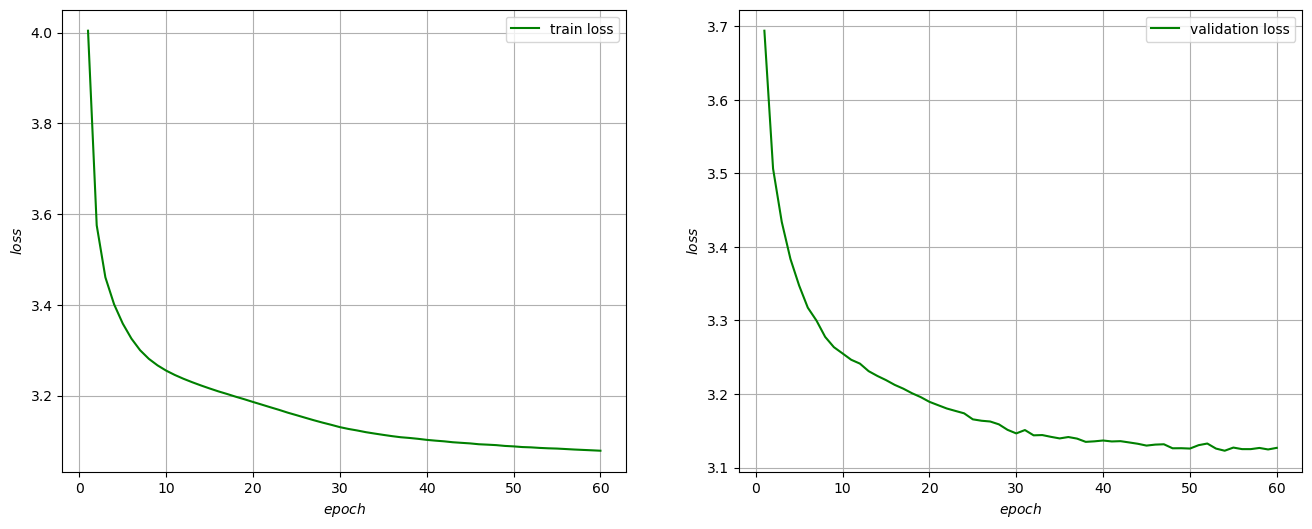

Current mean train loss: 3.078385829925537
min seen train loss: 3.078385829925537
Current train accuracy: 0.10213601026492565
Current train precision: 0.0011919190754200262
Current train recall: 0.0012093840053026459
Current validation loss: 3.126788854598999
min seen validation loss: 3.12288761138916
Current validation accuracy: 0.0968622893666473
Current validation precision: 0.0011215826307252343
Current validation recall: 0.0011270249741337083


In [327]:
set_random_seed(0xdeadbeef)

train_classification(model=years_classes_model,
                     optimizer=years_classes_model_optimizer,
                     criterion=years_classes_model_criterion,
                     train_loader=years_classes_train_loader,
                     test_loader=years_classes_test_loader,
                     metrics_averaging_mode=AveragingMode.Macro,
                     epochs_count=60)

In [328]:
set_random_seed(0xdeadbeef)

ten_classes_model = SimpleClassificationModel.from_x_y(X_train, y_ten_classes_train)
ten_classes_model_optimizer = SGD(ten_classes_model.mutable_parameters(), lr=0.002, weight_decay=0.01)
ten_classes_model_criterion = nn.CrossEntropyLoss()

In [329]:
assert test_classification(ten_classes_model,
                           ten_classes_model_criterion,
                           ten_classes_test_loader,
                           AveragingMode.Micro).shape[0] == y_ten_classes_test.shape[0]

Iterating over test dataset batches:   0%|          | 0/101 [00:00<?, ?it/s]

Mean loss over batches on the test dataset: 2.556725263595581
Accuracy: 0.09885725353476661
Precision: 0.010864798818155113
Recall: 0.010864798818155113


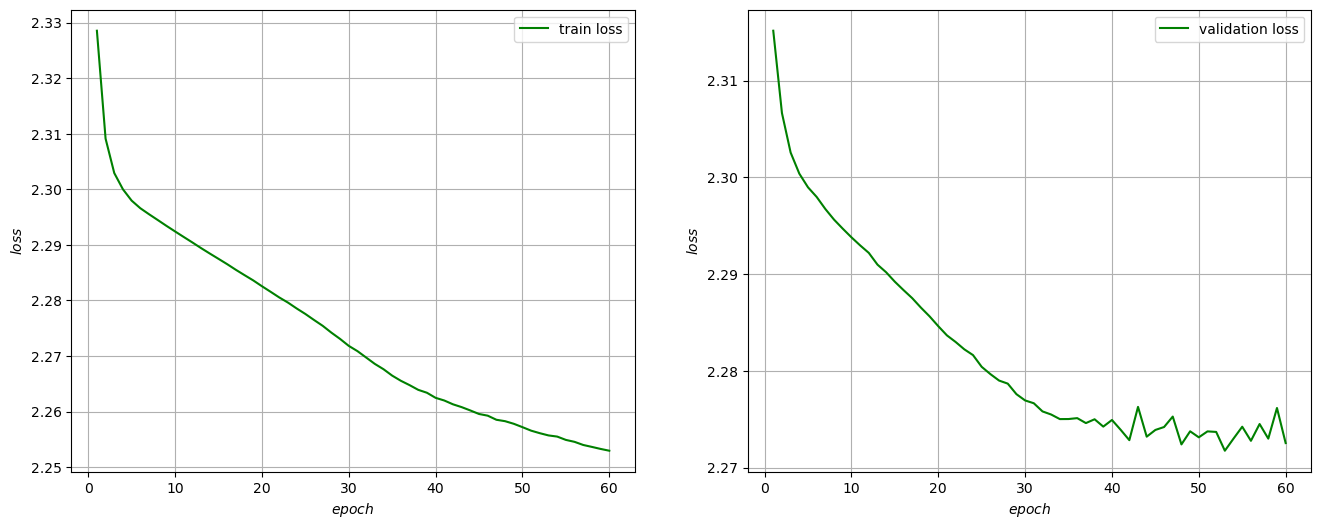

Current mean train loss: 2.252964496612549
min seen train loss: 2.252964496612549
Current train accuracy: 0.14029306794043755
Current train precision: 0.015348858827351528
Current train recall: 0.015348858827351528
Current validation loss: 2.272538900375366
min seen validation loss: 2.2717480659484863
Current validation accuracy: 0.1283556072051133
Current validation precision: 0.014061197079548565
Current validation recall: 0.014061197079548565


In [330]:
set_random_seed(0xdeadbeef)

train_classification(model=ten_classes_model,
                     optimizer=ten_classes_model_optimizer,
                     criterion=ten_classes_model_criterion,
                     train_loader=ten_classes_train_loader,
                     test_loader=ten_classes_test_loader,
                     metrics_averaging_mode=AveragingMode.Micro,
                     epochs_count=60)

У полученных моделей низкие метрики доли верных ответов, точности и отклика: примерно после 7-10 эпохи обучение сильно замедляется и лосс на трейне и тесте падают очень медленно. Эта задача отличается от предыдущей тем, что теперь у моделей "голова" обучается на n логитов, а не на 1, где n - число классов в классификации, между собой они отличаются тем, что у модели, обучающейся предсказание класса, соответствующего одному году, 89 выходов в последнем слое и сильно несбалансированные классы. Вторая модель обучается на 10 классов и классы сбалансированы, за счёт чего её качество немного выше, чем у первой (однако она также медленно обучается)
Для 1 модели было выбрано макро усреднение, т.к. в 1 случае классы сильно несбалансированные (метрики меньше учитывают размеры классов по сравнению с микро усреднением), а во втором - микро усреднение, т.к. при разбиении на 10 бинов классы получились сбалансированными